In [2]:
import findspark
findspark.init()

import pyspark

from secrets1 import username
from secrets1 import password

from pyspark.sql.functions import*
from pyspark.sql import SparkSession
import pandas as pd
import json
import re
from datetime import datetime
import mysql.connector as mariadb
import pyinputplus as pyinput
%matplotlib inline
import fontstyle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests


Create spark session

In [3]:
spark = SparkSession.builder.master("local[*]").appName("Capstone app").getOrCreate()

Extract data from JSON to DataFrame

In [8]:
def branch_extract():
    print("Extraxting branch data...")
    branch_df = spark.read.json("json_files/cdw_sapp_branch.json")
    return branch_df
def customer_extract():
    print("Extraxting customer data...")
    customer_df = spark.read.json("json_files/cdw_sapp_custmer.json")
    return customer_df
def credit_extract():
    print("Extraxting credit data...")
    credit_df = spark.read.json("json_files/cdw_sapp_credit.json")
    return credit_df
def credit_pandas_extract():
    print("Extraxting credit data...")
    #Read credit_json file into pandas dataframe
    credit_df_pandas = pd.read_json("json_files/cdw_sapp_credit.json", lines=True)
    return credit_df_pandas

Transformation of customer_df according to mapping document

In [9]:
def customer_transform(customer_df):
    print("Transformation of customer_df according to mapping document...")
    #convert First Name to Title case, Middle name in lower case, Last name in Title case
    customer_transform_df = customer_df.withColumn("FIRST_NAME", initcap(customer_df["FIRST_NAME"]))\
                             .withColumn("MIDDLE_NAME", lower(customer_df["MIDDLE_NAME"]))  \
                             .withColumn("LAST_NAME", initcap(customer_df["LAST_NAME"]))  
                             

    #Concatenate apartment no and street name of customer's residence with comma as a separator
    customer_transform_df = customer_transform_df.withColumn("FULL_STREET_ADDRESS", \
                            concat_ws(",",customer_df["APT_NO"],customer_df["STREET_NAME"]))

    #Drop column APT_NO and STREET_NAME
    customer_transform_df = customer_transform_df.drop("APT_NO","STREET_NAME")

    #change the data type of SSN,CUST_ZIP,CUST_PHONE,LAST_UPDATED
    customer_transform_df = customer_transform_df \
      .withColumn("SSN" ,customer_df["SSN"].cast('int'))   \
      .withColumn("CUST_ZIP",customer_df["CUST_ZIP"].cast('int'))   \
      .withColumn("CUST_PHONE",customer_df["CUST_PHONE"].cast('string'))   \
      .withColumn("LAST_UPDATED",customer_df["LAST_UPDATED"].cast('timestamp')) 

    #change the format of the phone number
    customer_transform_df = customer_transform_df.withColumn("CUST_PHONE", regexp_replace(col("CUST_PHONE") ,\
                             "(\\d{3})(\\d{4})" , "(155)$1-$2" ) )
    return customer_transform_df


Transformation of branch_df according to mapping document

In [10]:
def branch_transform(branch_df):
   print("Transformation of branch data according to mapping document...")
   #change the data type of BRANCH_CODE,BRANCH_ZIP,LAST_UPDATED
   branch_transform_df = branch_df \
      .withColumn("BRANCH_CODE" ,branch_df["BRANCH_CODE"].cast('int'))   \
      .withColumn("BRANCH_ZIP",branch_df["BRANCH_ZIP"].cast('int'))    \
      .withColumn("LAST_UPDATED",branch_df["LAST_UPDATED"].cast('timestamp')) 

   #change the format of the phone number
   branch_transform_df = branch_transform_df.withColumn("BRANCH_PHONE", regexp_replace(col("BRANCH_PHONE") ,\
                         "(\\d{3})(\\d{3})(\\d{4})" , "($1)$2-$3" ) )

   # If source value is null load default value (99999)
   branch_transform_df = branch_transform_df.na.fill(value=99999,subset=["BRANCH_ZIP"])
   return branch_transform_df


In [11]:
def branch_transform1(branch_df):
    print("Transformation of branch data according to mapping document...")
    branch_df.createOrReplaceTempView("branchview")
    branch_transform_df = spark.sql("SELECT CAST(BRANCH_CODE AS INT), BRANCH_NAME, BRANCH_STREET, BRANCH_CITY, \
                          BRANCH_STATE, CAST(IF(BRANCH_ZIP IS NULL, '99999', BRANCH_ZIP) AS INT) AS BRANCH_ZIP, \
                          CONCAT('(', SUBSTR(BRANCH_PHONE, 1, 3), ')', SUBSTR(BRANCH_PHONE, 4,3), '-', SUBSTR(BRANCH_PHONE, 7, 4)) AS BRANCH_PHONE, \
                          CAST(LAST_UPDATED AS TIMESTAMP) FROM BRANCHVIEW")
    return branch_transform_df


Transformation of credit_df according to mapping document - pandas

In [12]:
def credit_transform(credit_df_pandas):
    print("Transformation of credit data according to mapping document...")
    #change the data type of DAY,MONTH,YEAR
    credit_transform_df_pandas = credit_df_pandas.astype({"DAY":'str',"MONTH":'str',"YEAR":'str',"CREDIT_CARD_NO":'str'})
    credit_transform_df_pandas['DAY'] = credit_transform_df_pandas["DAY"].str.pad(2,side='left',fillchar='0')
    credit_transform_df_pandas['MONTH'] = credit_transform_df_pandas["MONTH"].str.pad(2,side='left',fillchar='0')
    
    #Converting DAY, MONTH, YEAR into a TIMEID (YYYYMMDD)
    credit_transform_df_pandas['TIMEID'] = credit_transform_df_pandas["YEAR"] + credit_transform_df_pandas["MONTH"] \
                                            + credit_transform_df_pandas["DAY"]
    
    #Drop column APT_NO and STREET_NAME
    credit_transform_df_pandas.drop(["DAY","MONTH","YEAR"],axis = 1,inplace = True)
    
    #Rename column CREDIT_CARD_NO to CUST_CC_NO 
    credit_transform_df_pandas.rename(columns = {"CREDIT_CARD_NO":"CUST_CC_NO"}, inplace = True)

    #converting pandas Dataframe to pyspark Dataframe
    credit_transform_df = spark.createDataFrame(credit_transform_df_pandas)

    #change the data type of BRANCH_CODE,CUST_SSN,TRANSACTION_ID
    credit_transform_df = credit_transform_df \
    .withColumn("BRANCH_CODE",credit_transform_df["BRANCH_CODE"].cast('int'))   \
    .withColumn("CUST_SSN",credit_transform_df["CUST_SSN"].cast('int'))   \
    .withColumn("TRANSACTION_ID",credit_transform_df["TRANSACTION_ID"].cast('int')) 

    return credit_transform_df


Data loading into Database

In [13]:
def branch_load(branch_transform_df):
       print("Loading transformed branch data into Database...")
       branch_transform_df.write.format("jdbc") \
       .mode("append") \
       .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
       .option("createTableColumnTypes", "BRANCH_NAME VARCHAR(30), BRANCH_CITY VARCHAR(30),\
              BRANCH_STREET VARCHAR(30), BRANCH_STATE VARCHAR(30) ,BRANCH_PHONE VARCHAR(14) ")  \
       .option("dbtable", "creditcard_capstone.CDW_SAPP_BRANCH") \
       .option("user", username) \
       .option("password", password) \
       .option("characterEncoding","UTF-8") \
       .option("useUnicode", "true") \
       .save()

def credit_load(credit_transform_df):
       print("Loading transformed credit data into Database...")
       credit_transform_df.write.format("jdbc") \
        .mode("append") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("createTableColumnTypes", "CUST_CC_NO VARCHAR(30), TRANSACTION_TYPE VARCHAR(30),\
               TIMEID VARCHAR(30)")  \
        .option("dbtable", "creditcard_capstone.CDW_SAPP_CREDIT_CARD") \
        .option("user", username) \
        .option("password", password) \
        .option("characterEncoding","UTF-8") \
        .option("useUnicode", "true") \
        .save()

def customer_load(customer_transform_df):
       print("Loading transformed customer data into Database...")
       customer_transform_df.write.format("jdbc") \
        .mode("append") \
        .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
        .option("createTableColumnTypes", "FIRST_NAME VARCHAR(30), MIDDLE_NAME VARCHAR(30),\
               LAST_NAME VARCHAR(30),CREDIT_CARD_NO VARCHAR(30),FULL_STREET_ADDRESS VARCHAR(50), \
               CUST_CITY VARCHAR(30),CUST_STATE VARCHAR(30),CUST_COUNTRY VARCHAR(30),  \
               CUST_PHONE VARCHAR(30),CUST_EMAIL VARCHAR(30)")  \
        .option("dbtable", "creditcard_capstone.CDW_SAPP_CUSTOMER") \
        .option("user", username) \
        .option("password", password) \
        .option("characterEncoding","UTF-8") \
        .option("useUnicode", "true") \
        .save()

In [14]:
# Log that you have started the ETL process
print("ETL Job Started")

# Log that you have started the Extract step
print("Extract phase Started")

# Call the Extract function
extracted_customer_data = customer_extract()
extracted_branch_data = branch_extract()
extracted_credit_data = credit_pandas_extract()

# Log that you have completed the Extract step
print("Extract phase Ended")

# Log that you have started the Transform step
print("Transform phase Started")

# Call the Transform function
customer_transformed_data = customer_transform(extracted_customer_data)
branch_transformed_data = branch_transform(extracted_branch_data)
credit_transformed_data = credit_transform(extracted_credit_data)

# Log that you have completed the Transform step
print("Transform phase Ended")

# Log that you have started the Load step
print("Load phase Started")

# Call the Load function
customer_load(customer_transformed_data)
branch_load(branch_transformed_data)
credit_load(credit_transformed_data)


# Log that you have completed the Load step
print("Load phase Ended")

# Log that you have completed the ETL process
print("ETL Job Ended")

ETL Job Started
Extract phase Started
Extraxting customer data...
Extraxting branch data...
Extraxting credit data...
Extract phase Ended
Transform phase Started
Transformation of customer_df according to mapping document...
Transformation of branch data according to mapping document...
Transformation of credit data according to mapping document...


C:\Spark\python\pyspark\sql\pandas\conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Transform phase Ended
Load phase Started
Loading transformed customer data into Database...
Loading transformed branch data into Database...
Loading transformed credit data into Database...
Load phase Ended
ETL Job Ended


2.1 Transaction Details Module

In [4]:
#load from database
def load_branch_from_db():
    branch_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_BRANCH").load()
    return branch_df


def load_credit_from_db():
    credit_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CREDIT_CARD").load()
    return credit_df


def load_customer_from_db():
    customer_df=spark.read.format("jdbc").options(driver="com.mysql.cj.jdbc.Driver",\
                                     user=username,\
                                     password=password,\
                                     url="jdbc:mysql://localhost:3306/companyabc_db",\
                                     dbtable="creditcard_capstone.CDW_SAPP_CUSTOMER").load()
    return customer_df

In [20]:
#create view from Spark DataFrame
def create_branch_view():
    branch_df = load_branch_from_db()
    branchview = branch_df.createOrReplaceTempView("branchview")
    return branchview
def create_customer_view():
    customer_df = load_customer_from_db()
    customerview = customer_df.createOrReplaceTempView("customerview")
    return customerview
def create_credit_view():
    credit_df = load_credit_from_db()
    creditview = credit_df.createOrReplaceTempView("creditview")
    return creditview
    

In [5]:
#validation functions
def common_validator(display_text_user, validator_method):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user)
        is_valid_input = validator_method(user_input_value)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True
            
#Transaction type (to check in the transaction type list) validator
def tr_type_validator(display_text_user, validator_method,validator_list):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user).title()
        is_valid_input = validator_method(user_input_value,validator_list)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

# State (to check from the branch state list) validator
def state_validator(display_text_user, validator_method,validator_list):
    is_valid_input = True
    while is_valid_input:
        user_input_value = input(display_text_user).upper()
        is_valid_input = validator_method(user_input_value,validator_list)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

#First name,Middle name and last name validator
def name_validator(display_text_user, validator_method,variable):
    is_valid_input = True
    while is_valid_input:
        if variable == "MIDDLE_NAME":
            user_input_value = input(display_text_user).lower()
        else:
            user_input_value = input(display_text_user).title()
        is_valid_input = validator_method(user_input_value)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True

# Home number and street address validator
def street_validator(validator_method):
    is_valid_input = True
    while is_valid_input:
        home_no = input("Please enter home or APT number: ")
        street_address = input("Please enter street address: ").title()
        user_input_value = home_no +','+ street_address
        is_valid_input = validator_method(home_no,street_address)
        if is_valid_input:
            return user_input_value
        else:
            print('Invalid input')
            is_valid_input = True


def validate_zip_code(zip_code):
    pattern = r'^\d{5}'
    return bool(re.match(pattern, str(zip_code)))

def validate_month(month):
    return True if month.isnumeric() and int(month) in list(range(1,13)) else False

def validate_year(year):
    return True if year.isnumeric() and int(year)==2018 else False

def validate_cc_no(cc_number):
    return True if cc_number.isnumeric() and len(cc_number) == 16 else False

def validate_ph_no(ph_no):
    return True if ph_no.isnumeric() and len(ph_no) == 10 else False

def validate_transaction_type(tr_type,tr_type_list):
    return True if tr_type.isalpha() and tr_type in tr_type_list else False

def validate_transaction_type(tr_type,tr_type_list):
    return True if tr_type.isalpha() and tr_type in tr_type_list else False

def validate_state(state_input,state_list):
    return True if state_input.isalpha() and state_input in state_list else False

def validate_name(name):
    return True if name.isalpha() and len(name) <20 else False

def validate_email(email):
    pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,7}\b'
    return bool(re.match(pattern, str(email)))

def validate_street(home_no,street):
    return True if home_no.isnumeric() else False

def validate_city(city):
    pattern = r"^[a-zA-Z]+(?:(?:\\s+|-)[a-zA-Z]+)*$"
    return bool(re.match(pattern, str(city)))

def validate_state_common(state):
    pattern = r"[A-Za-z]{2}"
    return bool(re.match(pattern, str(state)))

def validate_country(country):
    return True if country.lower() == 'united states' else False


In [6]:
#display the transactions made by customers living in a given zip code for a given month and year. Order by d
#descending order.
def transaction_for_zipcode():
        creditview= create_credit_view()
        customerview= create_customer_view()
        zipcode_input = common_validator("Enter 5-digit zip_code: ", validate_zip_code)
        month_input = common_validator("Enter month(in digits): ", validate_month)
        year_input = common_validator("Enter year: ", validate_year)

        #add padding for the month variable
        month_input = month_input.rjust(2,'0')

        query = f"select concat(FIRST_NAME,' ',MIDDLE_NAME,' ',LAST_NAME) as FULL_NAME, \
                TRANSACTION_ID,TRANSACTION_TYPE,round(TRANSACTION_VALUE,2) as TRANSACTION_VALUE, \
+                concat(FULL_STREET_ADDRESS,' ',CUST_CITY,' ',CUST_STATE) as ADDRESS, CUST_PHONE, \
                CUST_ZIP,TIMEID as TRANSACTION_DATE from creditview AS credit JOIN customerview\
                AS customer on customer.CREDIT_CARD_NO = credit.CUST_CC_NO WHERE \
                customer.CUST_ZIP = {zipcode_input} AND month(to_timestamp(TIMEID,'yyyyMMdd')) = '{month_input}' \
                AND YEAR(to_timestamp(TIMEID,'yyyyMMdd')) = '{year_input}' order by day(credit.TIMEID) desc"       
        spark.sql(query).show(truncate = False)

In [7]:
#display the number and total values of transactions for a given type.
def transaction_value_by_number():

    creditview= create_credit_view()

    #get unique transaction type list
    tr_type_query = f"select distinct(TRANSACTION_TYPE) from creditview"
    tr_type_df= spark.sql(tr_type_query)
    tr_type_list = tr_type_df.select('TRANSACTION_TYPE').rdd.map(lambda row : row[0]).collect()

    print("Transaction types: ",tr_type_list)
    tr_type_input = tr_type_validator("Enter Transaction Type: ", validate_transaction_type,tr_type_list)

    query = f"SELECT count(TRANSACTION_ID), round(SUM(TRANSACTION_VALUE),2) as TRANSACTION_VALUE \
                 FROM creditview \
                 WHERE TRANSACTION_TYPE = '{tr_type_input}' \
                 GROUP BY TRANSACTION_TYPE"
    spark.sql(query).show()	

In [8]:
#display the number and total values of transactions for branches in a given state
def transaction_branch_state():

    creditview= create_credit_view()
    branchview = create_branch_view()
    #get state list
    state_query = f"select distinct(BRANCH_STATE) from branchview"
    state_df= spark.sql(state_query)
    state_list =state_df.select('BRANCH_STATE').rdd.map(lambda row : row[0]).collect()

    print("state code list: ", state_list)
    state_input = state_validator("Enter two letter state code from the list: ", validate_state,state_list)

    # query = f"SELECT branch_state,credit.TRANSACTION_ID, SUM(credit.TRANSACTION_VALUE) \
                #  FROM cdw_sapp_branch AS branch INNER JOIN cdw_sapp_credit_card AS credit \
                #  ON branch.BRANCH_CODE = credit.BRANCH_CODE WHERE branch_state= '{state}' \
                #  GROUP BY credit.TRANSACTION_ID GROUP BY branch.branch_code"
    query= f"SELECT branch.BRANCH_CODE,count(TRANSACTION_ID),round(sum(TRANSACTION_VALUE),2) as TRANSACTIONS FROM branchview \
             AS branch INNER JOIN creditview AS credit ON branch.BRANCH_CODE = credit.BRANCH_CODE \
             WHERE BRANCH_STATE= '{state_input}' group by branch.BRANCH_CODE"

    spark.sql(query).show()	

2.2 Customer Details Module


In [9]:
#check the existing account details of a customer.
def account_details():
    customerview = create_customer_view()
    #check the existing account details of a customer.
    cc_no_input = common_validator("Enter 16-digit credit card number: ", validate_cc_no)


    #phone_input = re.sub(r"^(\d+)-", r"(\1)",phone_input)
    #formatted_phone_input= f"({phone_no_input[:3]}){phone_no_input[3:6]}-{phone_no_input[6:10]}"

    query= f"SELECT concat(FIRST_NAME,' ',MIDDLE_NAME,' ',LAST_NAME) as FULL_NAME,\
             FULL_STREET_ADDRESS,CUST_CITY as CITY, CUST_STATE as STATE,\
             CUST_COUNTRY as COUNTRY,CUST_ZIP as ZIP_CODE,CUST_PHONE as PHONE_NUMBER,CUST_EMAIL as EMAIL\
             from customerview where CREDIT_CARD_NO = '{cc_no_input}'"

    spark.sql(query).show()
    return cc_no_input

In [10]:
def customer_display(cc_no_input):
    customerview = create_customer_view()
    query= f"SELECT concat(FIRST_NAME,' ',MIDDLE_NAME,' ',LAST_NAME) as FULL_NAME,\
          FULL_STREET_ADDRESS,CUST_CITY as CITY, CUST_STATE as STATE,\
          CUST_COUNTRY as COUNTRY,CUST_ZIP as ZIP_CODE,CUST_PHONE as PHONE_NUMBER,CUST_EMAIL as EMAIL\
          from customerview where CREDIT_CARD_NO = '{cc_no_input}'"
    spark.sql(query).show()

In [11]:
#Establish Database connectivity and update
def update_customer(update_query_variable,user_update_input,credit_card_no_input):
    con=mariadb.connect(host="localhost",user=username,password=password,database="creditcard_capstone")
    cur=con.cursor()
    st=f"update cdw_sapp_customer set {update_query_variable} = '{user_update_input}'\
         where CREDIT_CARD_NO = '{credit_card_no_input}'"
    cur.execute(st)
    con.commit()
    cur.close()
    con.close()

In [12]:
def modify_customer():
    #modify the existing account details of a customer
    #check the existing account details of a customer.
    acc_no = account_details()
    #Get user input
    print('''Enter choice from below to update:
             1.Update First Name
             2.Update Last Name
             3.Update Middle Name
             4.Update phone Number
             5.Update Email
             6.Update Full_Street_Address
             7.Update city
             8.Update state
             9.Update Contry
             10.Update Zip_Code
             11.Display 
             12.Exit''')
    while True:
        user_choice = pyinput.inputInt("Please enter your choice from option 1 to 13:")
        if str(user_choice).isspace():
            print(" Invalid user choice ")
            user_choice = 0

        elif int(user_choice) in list(range(1,13)) ==False:
            print("Invalid user choice ")
            user_choice=0

        elif int(user_choice) == 1:
            update_query_variable = "FIRST_NAME"
            display_text = "Enter First Name: "
            first_name_input = name_validator(display_text,validate_name,update_query_variable)
            update_customer(update_query_variable,first_name_input,acc_no)
            print("Updated First Name!")

        elif int(user_choice) == 2:
            update_query_variable = "LAST_NAME"
            display_text = "Enter Last Name: "
            last_name_input = name_validator(display_text,validate_name,update_query_variable)
            update_customer(update_query_variable,last_name_input,acc_no)
            print("Updated Last Name!")

        elif int(user_choice) == 3:
            update_query_variable = "MIDDLE_NAME"
            display_text = "Enter Middle Name: "
            middle_name_input = name_validator(display_text,validate_name,update_query_variable)
            update_customer(update_query_variable,middle_name_input,acc_no)
            print("Updated Middle Name!")

        elif int(user_choice) == 4:
            update_query_variable = "CUST_PHONE"
            display_text = "Enter 10 digit phone number: "
            phone_no_input = common_validator(display_text,validate_ph_no)
            phone_no_input= f"({phone_no_input[:3]}){phone_no_input[3:6]}-{phone_no_input[6:10]}"
            update_customer(update_query_variable,phone_no_input,acc_no)
            print("Updated Phone Number!")

        elif int(user_choice) == 5:
            update_query_variable = "CUST_EMAIL"
            display_text = "Enter Email-id: "
            email_input = common_validator(display_text,validate_email)
            update_customer(update_query_variable,email_input,acc_no)
            print("Updated Email-id!")

        elif int(user_choice) == 6:
            update_query_variable = "FULL_STREET_ADDRESS"
            street_input = street_validator(validate_street)
            update_customer(update_query_variable,street_input,acc_no)
            print("Updated Full Street Address!")

        elif int(user_choice) == 7:
            update_query_variable = "CUST_CITY"
            display_text = "Enter City: "
            city_input = common_validator(display_text,validate_city)
            update_customer(update_query_variable,city_input,acc_no)
            print("Updated City!")

        elif int(user_choice) == 8:
            update_query_variable = "CUST_STATE"
            display_text = "Enter two letter State code: "
            state_input = common_validator(display_text,validate_state_common)
            state_input = state_input.upper()
            update_customer(update_query_variable,state_input,acc_no)
            print("Updated State!")

        elif int(user_choice) == 9:
            update_query_variable = "CUST_COUNTRY"
            display_text = "Enter country: "
            country_input = common_validator(display_text,validate_country)
            country_input = country_input.title()
            update_customer(update_query_variable,country_input,acc_no)
            print("Updated Country!")

        elif int(user_choice) == 10:
            update_query_variable = "CUST_ZIP"
            display_text = "Enter ZIP code: "
            zipcode_input = common_validator(display_text,validate_zip_code)
            update_customer(update_query_variable,zipcode_input,acc_no)
            print("Updated Zip_Code!")

        elif int(user_choice) == 11:
            customer_display(acc_no)
            
        elif int(user_choice) == 12:
            print("Exiting...")
            break


In [13]:
#generate a monthly bill for a credit card number for a given month and year.
def monthly_bill():
    creditview= create_credit_view()
    credit_card_input = input("Enter credit card number: ")
    month_input = input("Enter month:" )
    year_input = input("Enter year: ")
    
    qurey = query = f"SELECT CUST_CC_NO, ROUND(SUM(TRANSACTION_VALUE),2) as Monthly_Bill FROM creditview \
                      WHERE MONTH(to_date(TIMEID, 'yyyyMMdd')) = {month_input} AND \
                      YEAR(to_date(TIMEID, 'yyyyMMdd')) = {year_input} and CUST_CC_NO={credit_card_input} \
                      GROUP BY CUST_CC_NO"
    print(query)
    spark.sql(query).show()

In [15]:
#display the transactions made by a customer between two dates. Order by year, month, and day in descending order.
def transactions_by_dates():
        creditview= create_credit_view()
        credit_card_input = input("Enter credit card number: ")
        start_date_input = input("Enter start date: ")
        end_date_input = input("Enter End Date: ")

        query = f"SELECT TRANSACTION_ID,CUST_CC_NO,BRANCH_CODE,TRANSACTION_TYPE,TRANSACTION_VALUE,TIMEID FROM creditview \
                WHERE to_date(TIMEID, 'yyyyMMdd') >= '{start_date_input}' \
                AND to_date(TIMEID, 'yyyyMMdd') <= '{end_date_input}' \
                AND cust_cc_no = {credit_card_input} ORDER BY \
                YEAR(to_date(TIMEID, 'yyyyMMdd')) DESC, MONTH(to_date(TIMEID, 'yyyyMMdd')) DESC, \
                DAY(to_date(TIMEID, 'yyyyMMdd')) DESC"
        print(query)
        spark.sql(query).show()


In [15]:
def main_menu():

    while True:
        print(fontstyle.apply("\tFRONT END MENU",'bold/Italic/UNDERLINE'))
        print(fontstyle.apply('''\n\tEnter choice from below to see the data:
        1.Transaction Details
        2.Customer Details
        3.Exit''','Italic'))
        front_end_choice = pyinput.inputInt(fontstyle.apply("\n\tPlease enter your choice now: ",'Italic'))
        if front_end_choice == 1:
            transaction_details_menu()
        elif front_end_choice == 2:
            customer_details_menu()
        elif front_end_choice == 3:
            print("Exiting from main menu.....")
            break
        else:
            print("Please enter valid choice.....")


def transaction_details_menu():
    print(fontstyle.apply("\n\tYou have chosen to see transaction details.....",'Italic'))
    while True:
        print(fontstyle.apply('''\n\tPlease select from the below option: 
        1. Transactions made by customers - given zip_code, month and year 
        2. Display the number and total transaction value - given type
        3. Display the total number and transaction value for branches - given state
        4. Go back to front-end-module (Exit from Transaction details module)
        5. Exit from front-end menu''','Italic'))
        user_choice = pyinput.inputInt(fontstyle.apply("\n\tEnter your choice now: ",'Italic'))  
        if user_choice == 1:
            transaction_for_zipcode()
        elif user_choice == 2:
            transaction_value_by_number()
        elif user_choice == 3:
            transaction_branch_state()
        elif user_choice == 4:
            print(fontstyle.apply("\n\tExiting from Transaction Details....."))
            break
        elif user_choice == 5:
            print(fontstyle.apply("\nExiting from main menu",'Italic'))
            exit()
        else:
            print("Please enter valid choice...... ")
    
    
def customer_details_menu():
    print(fontstyle.apply("\n\tYou have chosen to see customer details.....",'Italic'))
    while True:
        print(fontstyle.apply('''\n\tPlease select from the below option: 
        1. Check existing account details of a customer
        2. Modify the existing account details of a customer
        3. Display Monthly bill for a credit card number - given month and year
        4. Display the transactions made by a customer between two dates
        5. Go back to front-end-module (Exit from Customer details module)
        6. Exit from Front-end menu''','Italic'))
        user_choice = pyinput.inputInt(fontstyle.apply("\nEnter your choice now: ",'Italic'))   
        if user_choice == 1:
            account_details()
        elif user_choice == 2:
            modify_customer()
        elif user_choice == 3:
            monthly_bill()
        elif user_choice == 4:
            transactions_by_dates()
        elif user_choice == 5:
            print("\n\tExiting from Customer Details.....")
            break
        elif user_choice == 6:
            print("\n\tExiting from main menu")
            exit()
        else:
            print("\tPlease enter a valid choice...... ")
    
main_menu()

	FRONT END MENU

	Enter choice from below to see the data:
    1.Transaction Details
    2.Customer Details
    3.Exit

	Please enter your choice now: 
	You have chosen to see transaction details.....

	Please select from the below option: 
    1. Transactions made by customers - given zip_code, month and year 
    2. Display the number and total transaction value - given type
    3. Display the total number and transaction value for branches - given state
    4. Go back to front-end-module (Exit from Transaction details module)
    5. Exit from front-end menu

	Enter your choice now: Invalid input
select concat(FIRST_NAME,' ',MIDDLE_NAME,' ',LAST_NAME) as FULL_NAME,                 TRANSACTION_ID,TRANSACTION_TYPE,round(TRANSACTION_VALUE,2) as TRANSACTION_VALUE,                 concat(FULL_STREET_ADDRESS,' ',CUST_CITY,' ',CUST_STATE) as ADDRESS, CUST_PHONE,                 CUST_ZIP,TIMEID as TRANSACTION_DATE from creditview AS credit JOIN customerview                AS customer on cust

: 

3 - Functional Requirements - Data analysis and Visualization

In [6]:
# load data to pandas dataframe
def load_to_branch_pandas():
    branch_df = load_branch_from_db()
    branch_df_pandas = branch_df.toPandas()
    return branch_df_pandas

def load_to_credit_pandas():
    credit_df = load_credit_from_db()
    credit_df_pandas = credit_df.toPandas()
    return credit_df_pandas

def load_to_customer_pandas():
    customer_df = load_customer_from_db()
    customer_df_pandas = customer_df.toPandas()
    return customer_df_pandas


In [1]:
#plot which transaction type has a high rate of transactions
def high_transaction_rate_type():
    credit_df_pandas = load_to_credit_pandas()
    tr_rate_df = credit_df_pandas[["TRANSACTION_TYPE","TRANSACTION_ID"]]
    tr_rate_df = tr_rate_df.groupby('TRANSACTION_TYPE')["TRANSACTION_ID"].count().sort_values(ascending = False)
    tr_rate_df.reset_index(inplace = True)
    tr_rate_df.plot(x = "TRANSACTION_TYPE", y="TRANSACTION_ID", kind = "bar",color='SteelBlue',figsize=(6, 4),bottom = 0.355)
    plt.xlabel("Transaction Type")
    plt.ylabel("Transaction ID")
    plt.title("Transaction Type with high Transaction Rate")
    #plt.grid(linestyle='dashed', axis="both",zorder=0.99,alpha = 0.15)
    #plt.yticks(list(range(0,500000,50000)))
    #plt.yticks([100000,200000,300000,400000,500000])
    #plt.xticks(np.arange(1,13,2))
    plt.show()

high_transaction_rate_type()

NameError: name 'load_to_credit_pandas' is not defined

C:\Spark\python\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


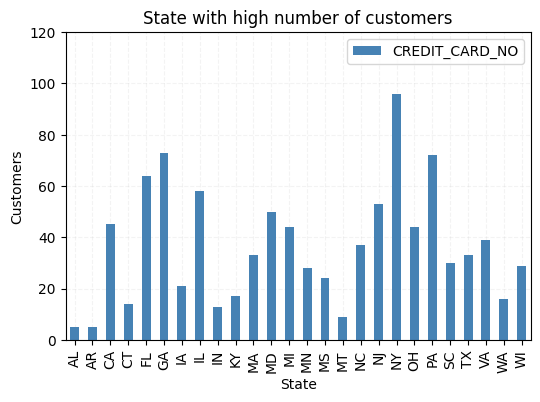

In [66]:
#plot which state has a high number of customers.
def high_customers_state():
    customer_df_pandas = load_to_customer_pandas()
    st_cust_df = customer_df_pandas[["CUST_STATE","CREDIT_CARD_NO"]]
    st_cust_df = st_cust_df.groupby(['CUST_STATE']).count()
    st_cust_df.reset_index(inplace = True)
    st_cust_df.plot(x = "CUST_STATE", y="CREDIT_CARD_NO", kind = "bar",color='SteelBlue',figsize=(6, 4))
    plt.xlabel("State")
    plt.ylabel("Customers")
    plt.title("State with high number of customers")
    plt.grid(linestyle='dashed', axis="both",zorder=0.99,alpha = 0.15)
    plt.yticks(list(range(0,140,20)))
    #plt.yticks([100000,200000,300000,400000,500000])
    #plt.xticks(np.arange(1,13,2))
    plt.show()
    
high_customers_state()

C:\Spark\python\pyspark\sql\pandas\conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


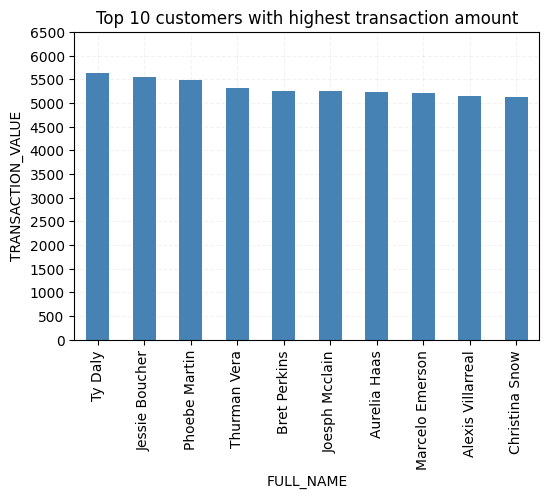

In [60]:
#sum of all transactions for the top 10 customers,and which customer has the highest transaction amount.
def top_ten_customers():
    customer_df_pandas = load_to_customer_pandas()   
    credit_df_pandas = load_to_credit_pandas() 
    top_cust_df = pd.merge(customer_df_pandas,credit_df_pandas,left_on='SSN',right_on='CUST_SSN',how="inner")
    top_cust_df = top_cust_df[["CUST_SSN","TRANSACTION_VALUE","FIRST_NAME","LAST_NAME"]]
    top_cust_df["FULL_NAME"] = top_cust_df["FIRST_NAME"]+" "+top_cust_df["LAST_NAME"]
    top_cust_df = top_cust_df.groupby('FULL_NAME')['TRANSACTION_VALUE'].sum().sort_values(ascending=False).head(10)
    #top_cust_df.reset_index(inplace = True)
    top_cust_df.plot(x = "FULL_NAME", y="TRANSACTION_VALUE", kind = "bar",color='SteelBlue',figsize=(6, 4))
    plt.xlabel("FULL_NAME")
    plt.ylabel("TRANSACTION_VALUE")
    plt.title("Top 10 customers with highest transaction amount")
    plt.grid(linestyle='dashed', axis="both",zorder=0.99,alpha = 0.15)
    plt.yticks(list(range(0,7000,500)))
    #plt.xticks(np.arange(1,13,2))
    plt.show()

top_ten_customers()

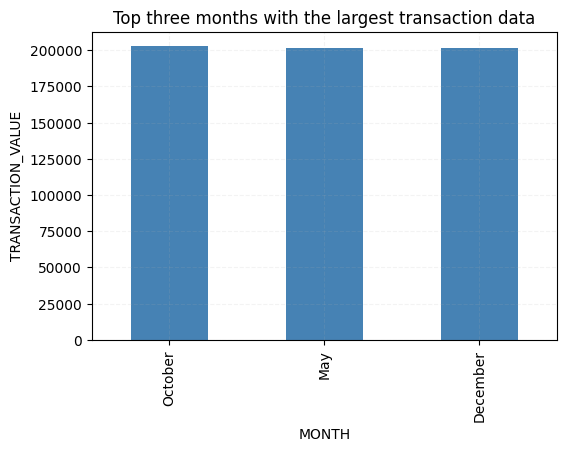

In [29]:
#top three months with the largest transaction data
credit_df_pandas = load_to_credit_pandas() 
largest_tr_df = credit_df_pandas[["TIMEID","TRANSACTION_VALUE"]]
largest_tr_df = largest_tr_df.astype({"TIMEID":'datetime64'})
largest_tr_df['MONTH'] = largest_tr_df['TIMEID'].dt.month_name()
largest_tr_df.drop(columns = 'TIMEID',inplace= True)
largest_tr_df = largest_tr_df.groupby('MONTH')['TRANSACTION_VALUE'].sum().sort_values(ascending=False).head(3)
largest_tr_df.plot(x = "MONTH", y="TRANSACTION_VALUE", kind = "bar",color='SteelBlue',figsize=(6, 4))
plt.xlabel("MONTH")
plt.ylabel("TRANSACTION_VALUE")
plt.title("Top three months with the largest transaction data")
plt.grid(linestyle='dashed', axis="both",zorder=0.99,alpha = 0.15)
#plt.yticks(list(range(0,7000,500)))


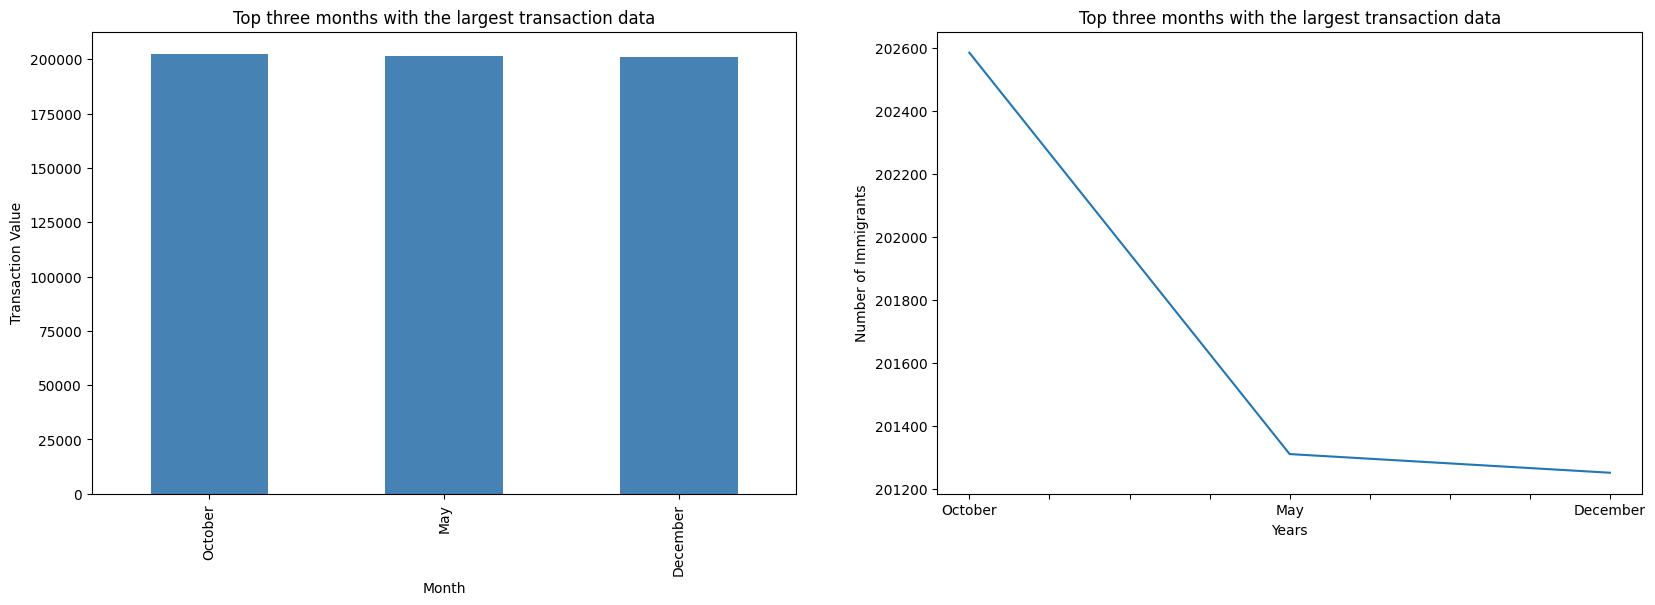

In [32]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 2, 1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Box plot
largest_tr_df.plot(kind='bar', color='SteelBlue', figsize=(20, 6), ax=ax0) # add to subplot 1
ax0.set_title('Top three months with the largest transaction data')
ax0.set_xlabel('Month')
ax0.set_ylabel('Transaction Value')

# Subplot 2: Line plot
largest_tr_df.plot(kind='line', figsize=(20, 6), ax=ax1) # add to subplot 2
ax1.set_title ('Top three months with the largest transaction data')
ax1.set_ylabel('Number of Immigrants')
ax1.set_xlabel('Years')

plt.show()

In [ ]:
#Data Visualization - Menu
def data_visualization_menu():
    print(fontstyle.apply("\n\tYou have chosen to see data visualization.....",'Italic'))
    
    while True:
        print(fontstyle.apply('''\n\tPlease select from the below option: 
        1. Transaction type that has a high rate oftransactions
        2. State that has a high number of customers
        3. Top 10 customers,and the customer that has the highest transaction amount
        4. Percentage of applications approved for self-employed applicants
        5. percentage of rejection for married male applicants
        6. Top three months with the largest transaction data
        7. branch processed the highest total dollar value of healthcare transactions
        8. Go back to front-end-module (Exit from Customer details module)
        9. Exit from Front-end menu''','Italic'))
        user_choice = pyinput.inputInt(fontstyle.apply("\n\tEnter your choice from data visualization menu: ",'Italic'))   
        if user_choice == 1:
            high_transaction_rate_type()
        elif user_choice == 2:
            high_customers_state()
        elif user_choice == 3:
            top_ten_customers()
        elif user_choice == 4:
            transactions_by_dates()
        elif user_choice == 5:
            transactions_by_dates()
        elif user_choice == 6:
            transactions_by_dates()
        elif user_choice == 7:
            transactions_by_dates()
        elif user_choice == 8:
            print(fontstyle.apply("\n\tExiting from Customer Details.....",'Italic'))
            break
        elif user_choice == 9:
            print(fontstyle.apply("\n\tExiting from main menu",'Italic'))
            exit()
        else:
            print(fontstyle.apply("\tPlease enter a valid choice...... ",'Italic'))


data_visualization_menu()

In [3]:
#loan api module
def loan_app():
    url = "https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json"
    print("Status code for the loan API: ",requests.get(url).status_code)
    loan_api_list = requests.get(url).json()
    loan_df=spark.createDataFrame(loan_api_list)
    return loan_df

def loan_load(loan_df):
    print("\t Loading loan data into Database....")
    loan_df.write.format("jdbc") \
    .mode("append") \
    .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
    .option("dbtable", "creditcard_capstone.CDW_SAPP_loan_application") \
    .option("user", username) \
    .option("password", password) \
    .option("characterEncoding","UTF-8") \
    .option("useUnicode", "True") \
    .save()
    
def loan_to_pandas(loan_df):
    loan_df_pandas = loan_df.toPandas()
    return loan_df_pandas


loan_df = loan_app()
loan_load(loan_df)



Status code for the loan API:  200
	 Loading loan data into Database....


In [4]:
loan_df_pandas = loan_to_pandas(loan_df)
loan_df_pandas.head()

,Application_ID,Application_Status,Credit_History,Dependents,Education,Gender,Income,Married,Property_Area,Self_Employed
0,LP001002,Y,1,0,Graduate,Male,medium,No,Urban,No
1,LP001003,N,1,1,Graduate,Male,medium,Yes,Rural,No
2,LP001005,Y,1,0,Graduate,Male,low,Yes,Urban,Yes
3,LP001006,Y,1,0,Not Graduate,Male,low,Yes,Urban,No
4,LP001008,Y,1,0,Graduate,Male,medium,No,Urban,No


In [88]:
print(len(loan_df_pandas))

def percentage_self_employed(loan_df_pandas):
    count = len(loan_df_pandas.index)
    self_emp_df = loan_df_pandas[loan_df_pandas['Self_Employed'] == 'Yes']+[loan_df_pandas['Application_Status'] == 'Y']
    print(len(self_emp_df))
    

percentage_self_employed(loan_df_pandas)

511


ValueError: Unable to coerce list of <class 'pandas.core.series.Series'> to Series/DataFrame

In [27]:
##plot the percentage of applications approved for self-employed applicants.
#df = loan_df_pandas[['Self_Employed','Application_Status']]
# df1=df[df['Self_Employed'] == 'Yes'].groupby('Application_Status').value_counts()
#df1.head()

In [39]:
df0 = loan_df_pandas.groupby(['Self_Employed','Application_Status']).count().to_frame('Size')
df1 = df0.unstack(level=1).apply(lambda row: 100*row/sum(row), axis=1)
df2 = df0.unstack(level=0).apply(lambda row: 100*row/sum(row), axis=1)
df3 = 100*df0.unstack(level=1)/df0.sum().sum()

AttributeError: 'DataFrame' object has no attribute 'to_frame'

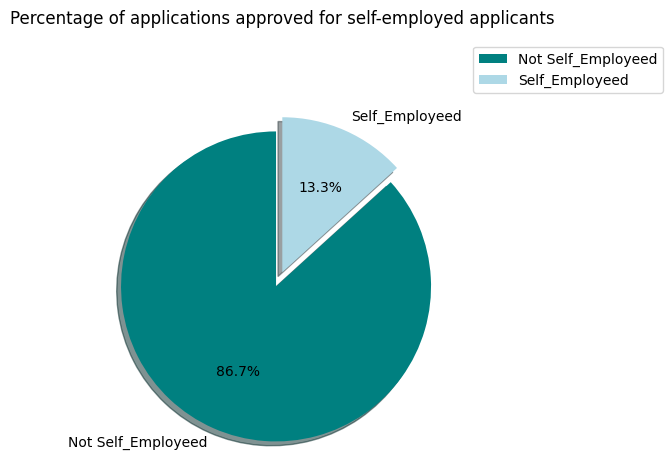

In [18]:
color_list = ['Teal','lightBlue']
label_value = ['Not Self_Employeed','Self_Employeed']
explode_list =[0.1,0]
df=loan_df_pandas[loan_df_pandas['Application_Status']== 'Y'][['Self_Employed']].value_counts()
df.plot(kind='pie',
       figsize=(5, 6),
       autopct='%1.1f%%',
       startangle=90,    
       shadow=True,  
       labels = label_value, 
       colors = color_list,
       explode=explode_list   
         )
plt.title('Percentage of applications approved for self-employed applicants', y=1.12) 
plt.legend(labels=label_value, bbox_to_anchor=(1.5,1.1),loc='upper right')

plt.show()

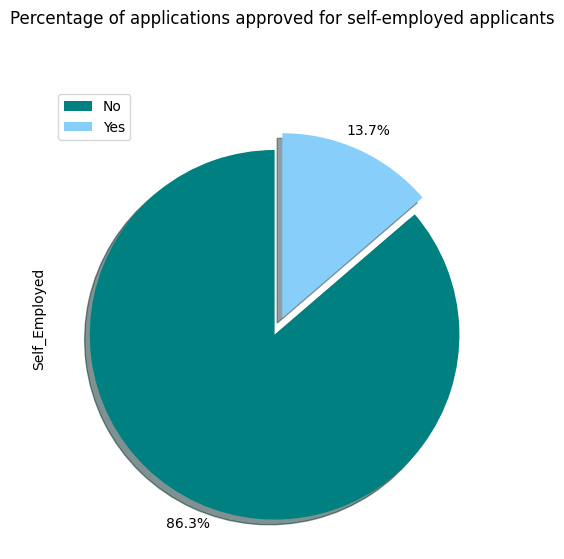

In [46]:
color_list = ['Teal','lightskyBlue']
explode_list =[0.1,0]
df = loan_df_pandas['Self_Employed'].value_counts()
df.plot(kind='pie',
       figsize=(15, 6),
       autopct='%1.1f%%', 
       startangle=90,    
       shadow=True,       
       labels=None,        
       pctdistance=1.12,  
       colors = color_list,
       explode=explode_list
       )
plt.title('Percentage of applications approved for self-employed applicants', y=1.12) 
plt.legend(labels=df.index, loc='upper left') 

plt.show()

In [14]:
def percentage_rej_married_male(loan_df_pandas):
    count = len(loan_df_pandas.index)
    self_emp_df = loan_df_pandas.loc[loan_df_pandas['Gender'] == 'Male']
    self_emp_df = self_emp_df.loc[loan_df_pandas['Application_Status'] == 'N']
    self_emp_df = self_emp_df.loc[loan_df_pandas['Married'] == 'Yes']
    print(len(self_emp_df))


percentage_rej_married_male(loan_df_pandas)

87


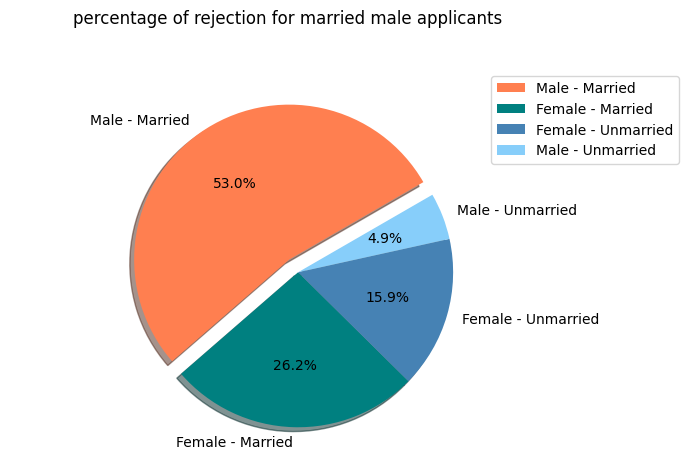

In [94]:
color_list = colors_list = ['Coral', 'Teal', 'SteelBlue', 'lightskyblue']
explode_list =[0.1,0,0,0]
df = loan_df_pandas[['Gender','Married']][loan_df_pandas['Application_Status'] == 'N'].value_counts()
label_value=['Male - Married','Female - Married','Female - Unmarried','Male - Unmarried']
df.plot(kind='pie',
       figsize=(5, 6),
       autopct='%1.1f%%',
       startangle=30,    
       shadow=True, 
       labels = label_value,    
       colors = color_list,
       explode=explode_list
       )
plt.title('            percentage of rejection for married male applicants                ', y=1.12) 
plt.legend(labels=label_value, bbox_to_anchor=(1.5,1.025),loc='upper right') 
